In [1]:
!ls '/kaggle/input/grocery-item-images/Grocery item images'

test  train


In [2]:
TEST = '/kaggle/input/grocery-item-images/Grocery item images/test'
TRAIN = '/kaggle/input/grocery-item-images/Grocery item images/train'

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 184MB/s]


In [4]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'] )
        for index, input_file in enumerate(list(iglob(pathname=arg)))]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
test_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TEST + '/*') }
test_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in test_dict.items()]))
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') }
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
train_df['tag'] = train_df['tag'].apply(func=lambda x: 'Bean' if x == 'Beans' else x)
print('done in {}'.format(arrow.now() - time_start))

encoded 20 rows of Tomato  in 0:00:02.702983
encoded 20 rows of Apple  in 0:00:02.521827
encoded 20 rows of Bean  in 0:00:02.643873
encoded 20 rows of Lemon  in 0:00:02.541188
encoded 20 rows of Banana  in 0:00:02.601376
encoded 20 rows of Onion  in 0:00:02.690442
encoded 20 rows of Potato  in 0:00:02.787134
encoded 180 rows of Tomato  in 0:00:23.275522
encoded 180 rows of Apple  in 0:00:23.414403
encoded 180 rows of Beans  in 0:00:23.844288
encoded 180 rows of Lemon  in 0:00:23.739991
encoded 180 rows of Banana  in 0:00:23.604456
encoded 180 rows of Onion  in 0:00:23.801621
encoded 180 rows of Potato  in 0:00:24.626838
done in 0:03:04.900331


In [5]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))
test_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
test_df[['x', 'y']] = test_reducer.fit_transform(X=test_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1260 samples in 0.006s...
[t-SNE] Computed neighbors for 1260 samples in 0.229s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1260
[t-SNE] Computed conditional probabilities for sample 1260 / 1260
[t-SNE] Mean sigma: 4.084277
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.347183
[t-SNE] KL divergence after 1000 iterations: 0.394143
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 140 samples in 0.001s...
[t-SNE] Computed neighbors for 140 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 140 / 140
[t-SNE] Mean sigma: 6.183970
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.724678
[t-SNE] KL divergence after 800 iterations: 0.166782


In [6]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']])
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: produce', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=12, color=mapper)
show(plot_figure)

Loading BokehJS ...

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

logreg = LogisticRegression(max_iter=600, tol=1e-12).fit(train_df['value'].apply(func=pd.Series), train_df['tag'])
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series)))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series)))))
print(classification_report(zero_division=0.0, y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series))))

model fit in 173 iterations
accuracy: 1.0000
f1: 1.0000
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        20
      Banana       1.00      1.00      1.00        20
        Bean       1.00      1.00      1.00        20
       Lemon       1.00      1.00      1.00        20
       Onion       1.00      1.00      1.00        20
      Potato       1.00      1.00      1.00        20
      Tomato       1.00      1.00      1.00        20

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



<Axes: xlabel='probability', ylabel='Count'>

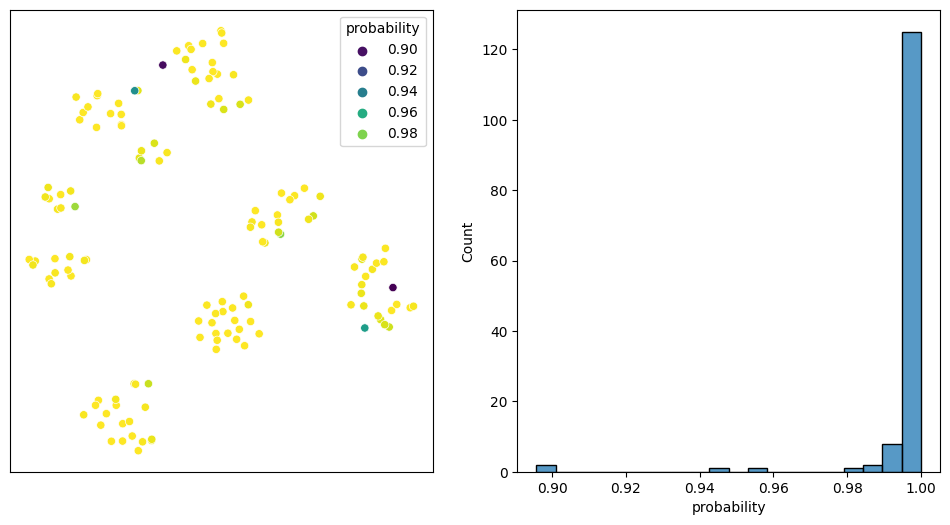

In [8]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = test_df[['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=test_df['value'].apply(func=pd.Series)), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)